In [17]:
import json
import math
import random
from pathlib import Path
from pprint import pprint
from utils import load_dataset, create_dataset, write_test_data, gpt_prediction, eval_response, results_path

output_dir = results_path / "sentence_length_tiled_sorted_margin"
if not output_dir.exists():
    output_dir.mkdir(parents=True)
dataset, tag_counts = load_dataset("sentences.json")
print(len(dataset))
pprint(tag_counts)

200
{'all_lower': 78,
 'all_upper': 59,
 'animate': 1,
 'city': 25,
 'even_words': 97,
 'fragment_subject': 20,
 'fragment_verb': 20,
 'gpt4': 200,
 'long': 108,
 'long_margin': 60,
 'nature': 62,
 'odd_words': 103,
 'proper_noun': 32,
 'sentence': 160,
 'shared_sample': 42,
 'short': 92,
 'short_margin': 140,
 'start_cap': 121,
 'start_consonant': 171,
 'start_lower': 79,
 'start_the': 57,
 'start_vowel': 29}


In [26]:
# fragments vs sentence; just subject/verb fragments vs all; test if class balance changes accuracy
tags_true = ["short_margin"]
tags_false = ["long_margin"]
tags_common = []
positives, negatives = create_dataset(dataset, tags_true, tags_false, tags_common, true_comb="AND", false_comb="AND")

with open(output_dir / "dataset_tags.txt", "w") as f:
    f.write(f"tags_true: {tags_true}\n")
    f.write(f"tags_false: {tags_false}\n")
    f.write(f"tags_common: {tags_common}\n")

print(len(positives), len(negatives))

140 60


In [19]:
pprint(positives)

[{'input': 'ALWAYS STRIVE FOR EXCELLENCE.',
  'label': True,
  'tags': ['start_cap',
           'shared_sample',
           'even_words',
           'short',
           'sentence',
           'start_vowel',
           'all_upper',
           'short_margin',
           'gpt4']},
 {'input': 'Gardening provides a connection to nature.',
  'label': True,
  'tags': ['start_cap',
           'even_words',
           'start_consonant',
           'short_margin',
           'short',
           'sentence',
           'gpt4']},
 {'input': 'BE KIND TO ONE ANOTHER.',
  'label': True,
  'tags': ['start_cap',
           'odd_words',
           'short',
           'sentence',
           'all_upper',
           'start_consonant',
           'short_margin',
           'gpt4']},
 {'input': 'KNOWLEDGE IS POWER.',
  'label': True,
  'tags': ['start_cap',
           'odd_words',
           'short',
           'sentence',
           'all_upper',
           'start_consonant',
           'short_margin',
      

In [20]:
pprint(negatives)

[{'input': 'FRIENDSHIP IS LIKE A SHINING STAR IN THE DARK.',
  'label': False,
  'tags': ['start_cap',
           'long',
           'odd_words',
           'shared_sample',
           'long_margin',
           'sentence',
           'start_consonant',
           'all_upper',
           'gpt4']},
 {'input': 'DREAM BIG AND WORK HARD TO ACHIEVE IT.',
  'label': False,
  'tags': ['start_cap',
           'long',
           'shared_sample',
           'even_words',
           'long_margin',
           'sentence',
           'start_consonant',
           'all_upper',
           'gpt4']},
 {'input': 'the quick brown fox jumps over the lazy dog.',
  'label': False,
  'tags': ['long',
           'odd_words',
           'shared_sample',
           'nature',
           'long_margin',
           'sentence',
           'start_lower',
           'start_consonant',
           'start_the',
           'gpt4',
           'all_lower']},
 {'input': 'The Grand Canyon is a breathtaking natural formation.',


In [21]:
# sample_counts = [3, 5, 10, 15, 30]
sample_counts = [30]
response_jsons = []
sort_len = lambda x: len(x.split())
for c in sample_counts:
    write_test_data(positives, negatives, c, output_dir, max_test_ct=50, tiled=True, prompt_sort_by=sort_len)
    in_context_prompt = open(output_dir / f"in_context_prompt_{c}.txt").read()
    test_prompt = open(output_dir / f"test_prompt_{c}.txt").read()
    test_samples = json.load(open(output_dir / f"test_samples_{c}.json"))
    response_json = gpt_prediction(in_context_prompt, test_prompt, json_mode=True)
    json.dump(response_json, open(output_dir / f"response_{c}.json", "w"))
    response_jsons.append(response_json)

/Users/ishangaur/classification-faithfulness/utils.py:106: UserWarning: json_mode only supported for gpt-4-1106-preview
  warn("json_mode only supported for gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:107: UserWarning: changing model to gpt-4-1106-preview
  warn("changing model to gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:110: UserWarning: json_mode is on but user_query does not contain "json"
  warn("json_mode is on but user_query does not contain \"json\"")
/Users/ishangaur/classification-faithfulness/utils.py:111: UserWarning: adding prefix to user_query:
"Please label the following inputs. Respond in JSON format like the examples given to you above."
  warn(f"adding prefix to user_query:\n\"{json_prefix}\"")


In [22]:
sample_counts = [3, 5, 10, 15, 30]
response_jsons = [json.load(open(output_dir / f"response_{c}.json")) for c in sample_counts]
test_samples = [json.load(open(output_dir / f"test_samples_{c}.json")) for c in sample_counts]

results = []
responses = []
for r, t in zip(response_jsons, test_samples):
    response, result = eval_response(r, t)
    results.append(result)
    responses.append(response)

In [23]:
for c, r in zip(sample_counts, results):
    r["in_context_count"] = c
pprint(results)

[{'accuracy': 0.39,
  'correct': 39,
  'corrupted': 0,
  'in_context_count': 3,
  'incorrect': 61,
  'mismatch': 0,
  'total': 100},
 {'accuracy': 0.59,
  'correct': 59,
  'corrupted': 0,
  'in_context_count': 5,
  'incorrect': 41,
  'mismatch': 0,
  'total': 100},
 {'accuracy': 0.6,
  'correct': 60,
  'corrupted': 0,
  'in_context_count': 10,
  'incorrect': 40,
  'mismatch': 0,
  'total': 100},
 {'accuracy': 0.64,
  'correct': 64,
  'corrupted': 0,
  'in_context_count': 15,
  'incorrect': 36,
  'mismatch': 0,
  'total': 100},
 {'accuracy': 0.5,
  'correct': 30,
  'corrupted': 0,
  'in_context_count': 30,
  'incorrect': 30,
  'mismatch': 0,
  'total': 60}]


In [24]:
json.dump(responses, open(output_dir / "responses.json", "w"))
json.dump(results, open(output_dir / "results.json", "w"))

                  correct  mismatch  incorrect  corrupted  test_total
in_context_count                                                     
3                    0.39       0.0       0.61        0.0    0.970874
5                    0.59       0.0       0.41        0.0    0.970874
10                   0.60       0.0       0.40        0.0    0.970874
15                   0.64       0.0       0.36        0.0    0.970874
30                   0.50       0.0       0.50        0.0    0.582524


Text(0.5, 1.0, 'Short (<7) vs Long Tiled (n=103, T=1)')

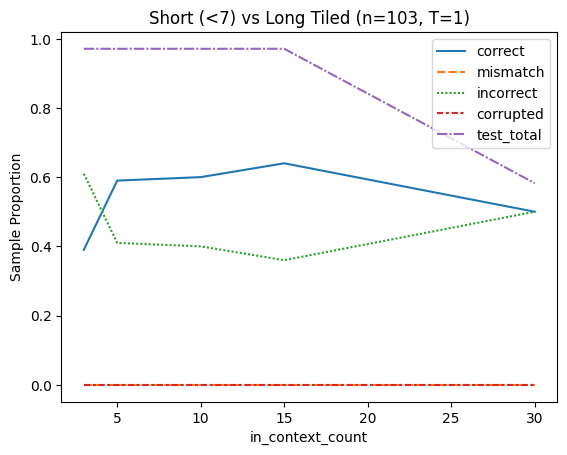

In [25]:
import pandas as pd
import seaborn as sns

results = json.load(open(output_dir / "results.json"))

df = pd.DataFrame(results)
df.drop(columns=["accuracy"], inplace=True)
total_samples = df["total"].max() + df["in_context_count"].min()

for col in df.columns:
    if col == "total":
        df[col] /= total_samples
    elif col == "in_context_count":
        continue
    else:
        df[col] /= df["total"]
df["test_total"] = df["total"]
df.drop(columns=["total"], inplace=True)
df.set_index("in_context_count", inplace=True)
print(df)

ax = sns.lineplot(data=df)
ax.set_ylabel("Sample Proportion")
ax.set_title(f"Short (<7) vs Long Tiled (n={total_samples}, T=1)")